In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import nltk
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as km

import hdbscan
from sklearn.cluster import DBSCAN


# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

### Stemming & tokenizing & Word2vec

In [25]:
path = "../../datas/"
naver = pd.read_csv(path+"v5_category_re_token_sum.csv")
kakao = pd.read_csv(path+"kakao_review_cat_predict_token_sum.csv")

n_reviews = naver[['highlight_review', 'category']].copy()
n_reviews.rename(columns={"highlight_review": 'review'}, inplace=True)
k_reviews = kakao[['contents', 'category']].copy()
k_reviews.dropna(axis=0, inplace=True)
k_reviews.rename(columns={"contents": 'review'}, inplace=True)

data = pd.concat([n_reviews, k_reviews], axis=0).reset_index()

In [50]:
stopwords = ['',' ''다','좀', '있다', '조금', '요', '되어다', '더', '다' '너', '친', '가자', '아주', '그렇다', '바라','싶다','습니다','좀',
             '및', '...', '도', '수', '나다', '엄청', '것', '점', '등', '등등', '사', '에', '옆','이다','보다', '되다', '항상', '어요'
            , '실', '만', '정', '아', '깨', '안', '없', '무', '또', '시']

new_list = []
for r in range(len(data)):
    try: 
        rv = data['review'].iloc[r]
        rv = rv.split(" ")
        rv.append(data['category'].iloc[r])
        rv = [re.compile('[^가-힣]+').sub("", r) for r in rv]
        rv = [re.compile('[은, 는, 도]+').sub("", r) for r in rv]
        rv = [r.replace(r, "") if len(r)<1 or r in stopwords else r for r in rv]
        new_list.append(rv)

    except:
        new_list.append("")

# vocabs = [word for word in new_list if word not in stopwords and len(word)>1]
print("total words num: ", len(new_list))
data['cat_plus_rv'] = new_list
reviews = data['cat_plus_rv']
model = Word2Vec(reviews, sg=1, # skinp-gram: 중심단어로 주변단어 예측
                 vector_size=2,
                 workers=6, 
                 window=5,      # 중심 단어로부터 좌우 n개까지 학습에 적용
                 min_count=100, # 전체 문서에서 최소 n회 이상 출현 단어로 학습
                 sample=0.001
                ) 

word_vectors = model.wv.vectors

vocabs = list(model.wv.index_to_key)
word_vectors_list = [model.wv[v] for v in vocabs]

print(len(word_vectors), len(vocabs), vocabs)

total words num:  124707
437 437 ['좋다', '', '메인시설', '서비스', '친절하다', '만족', '너무', '사장님', '깨끗하다', '분위기', '청결', '부대공용시설', '시설', '위치', '전망', '화장실', '수영장', '자다', '깔끔하다', '하다', '정말', '많다', '만족하다', '가격', '다', '없다', '사장님이', '뷰', '계곡', '개수대', '넘다', '오다', '가깝다', '시설이', '넓다', '모두', '가다', '경치', '샤워실', '직원분들', '조용하다', '괜찮다', '아쉽다', '샤워장', '음식조식', '매우', '관리', '따뜻하다', '않다', '비품', '편하다', '방', '캠핑장', '친절', '너무좋다', '관리가', '만족스럽다', '글램핑', '뷰가', '진짜', '놀다', '같다', '불편하다', '너무너무', '화장실이', '사이트', '들다', '잘되어다', '내부', '주변', '예쁘다', '많이', '사장님께서', '계곡이', '청결하다', '풍경', '쉬다', '온수', '벌레', '최고이다', '바로', '카라반', '이쁘다', '나오다', '바베큐', '고', '안되다', '완전', '좋아하다', '크다', '벌레가', '최고', '생각보다', '편의시설', '물', '멀다', '분위기가', '다음에', '아이들', '시원하다', '차다', '경치가', '맛있다', '나무', '바다', '아니다', '즐겁다', '저렴하다', '잘되다', '이용하다', '매점', '숙소', '너무친절하다', '잘나오다', '예약', '깨끗', '힘들다', '좁다', '경치좋다', '이', '앞에', '수영장이', '아이들이', '사모님', '매너타임', '작다', '맘에', '굿', '보내다', '시설깨끗하다', '공기', '물놀이', '굉장하다', '비싸다', '재밌다', '해주다', '화장실과', '마음에', '사장님들', '캠핑', '가성비', '사장님친절

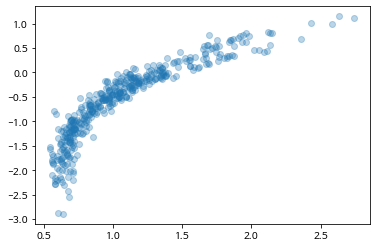

In [4]:
plt.scatter(word_vectors.T[0], word_vectors.T[1], alpha=0.3)
plt.show()

### 차원축소를 하지 않으면 전혀 군집이 되지 않음

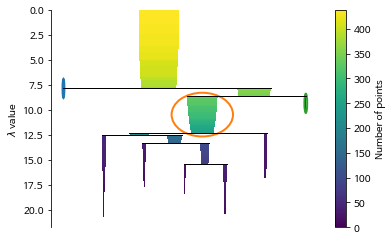

In [27]:
import hdbscan
from sklearn.cluster import DBSCAN

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(word_vectors)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [28]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5).fit(word_vectors)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(word_vectors)

# 데이터 프레임 만들기
df = pd.DataFrame(word_vectors)
df["labels"] = pred_hds
df.index = vocabs

print(np.unique(df["labels"]))
df.tail(2)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]


,0,1,labels
캠장,0.506383,0.993620,5
스파,0.805123,0.724959,-1


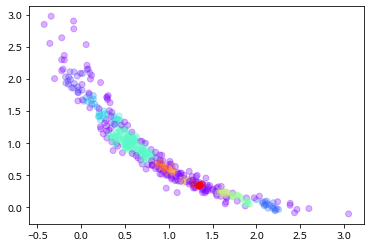

In [29]:
plt.scatter(df[0], df[1], c=df["labels"], cmap="rainbow", alpha=0.3)
plt.show()

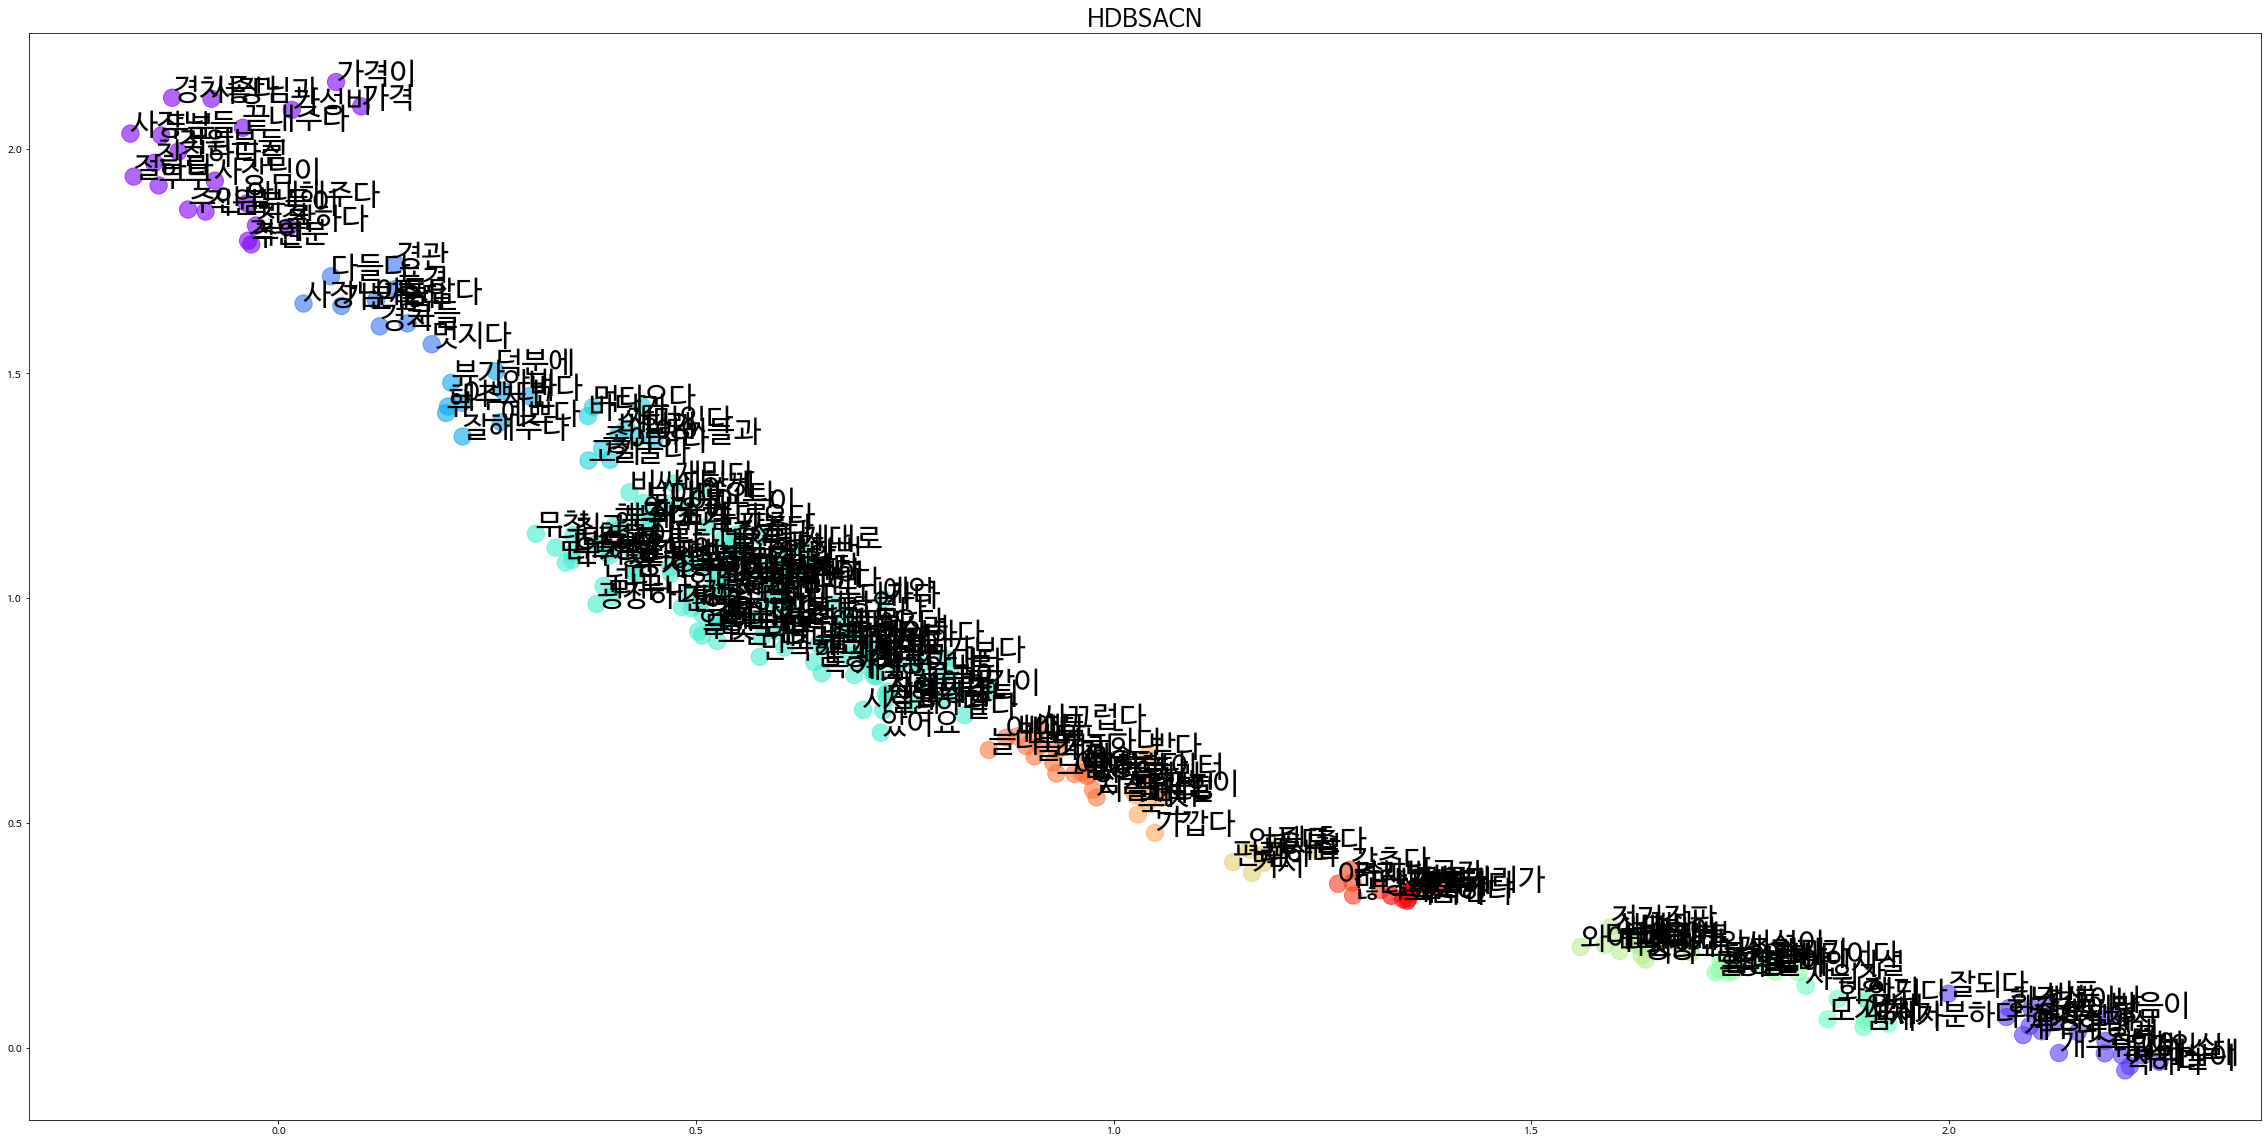

In [30]:
plt.figure(figsize=(40, 20))
plt.title("HDBSACN", fontsize= 25)
df.drop(df[df['labels']== -1].index,inplace=True)
plt.scatter(df[0], df[1], c= df["labels"], s=300, cmap="rainbow", alpha=0.6)

for i, v in enumerate(df.index):
    plt.annotate(v, xy=(df[0][i], df[1][i]), fontsize=30)

plt.show()

In [31]:
for idx in np.unique(df["labels"]):
    print(f"Group{idx}\n",df[df["labels"]==idx].index.tolist())

Group0
 ['가격', '사장님이', '직원분들', '친절', '경치좋다', '사장님들', '가성비', '주인', '직원분', '주인분', '직원분들이', '착하다', '사장님과', '가격이', '끝내주다', '부부', '친절하다심', '절하다', '두분', '안내해주다']
Group1
 ['화장실', '개수대', '샤워실', '비품', '벌레', '잘되다', '난방', '바닥', '모기', '개수대가', '샤워실이', '화장실이랑', '약하다', '화', '화장실이나', '방음이', '화장실에', '수압이', '계수대']
Group2
 ['경치', '사장님께서', '풍경', '멋지다', '분들', '아름답다', '경관', '다들다', '기분좋다']
Group3
 ['뷰', '뷰가', '예쁘다', '이쁘다', '바다', '잘해주다', '덕분에', '해주시고', '안내']
Group4
 ['오다', '좋아하다', '바다가', '재미있다', '먹다', '바닷가', '고기', '힐링', '아이들과', '잘놀다']
Group5
 ['좋다', '너무', '분위기', '위치', '하다', '정말', '만족하다', '계곡', '넘다', '가다', '조용하다', '캠핑장', '너무좋다', '진짜', '놀다', '같다', '들다', '계곡이', '최고이다', '바로', '최고', '바베큐', '분위기가', '다음에', '시원하다', '차다', '예약', '앞에', '아이들이', '매너타임', '공기', '물놀이', '굉장하다', '해주다', '재밌다', '비싸다', '캠핑', '잘하다', '편안하다', '앞', '무엇보다', '곳', '예약하다', '갈다', '다른', '주다', '가보다', '니다', '즐기다', '놀다오다', '계곡물', '방문하다', '여기', '운치있다', '너무나', '보이다', '관리를', '자리', '특히', '위치가', '다녀오다', '그', '밤에', '넘다좋다', '접근성', '딱', '한적하다', '만족이다', '지키다', '일단', '

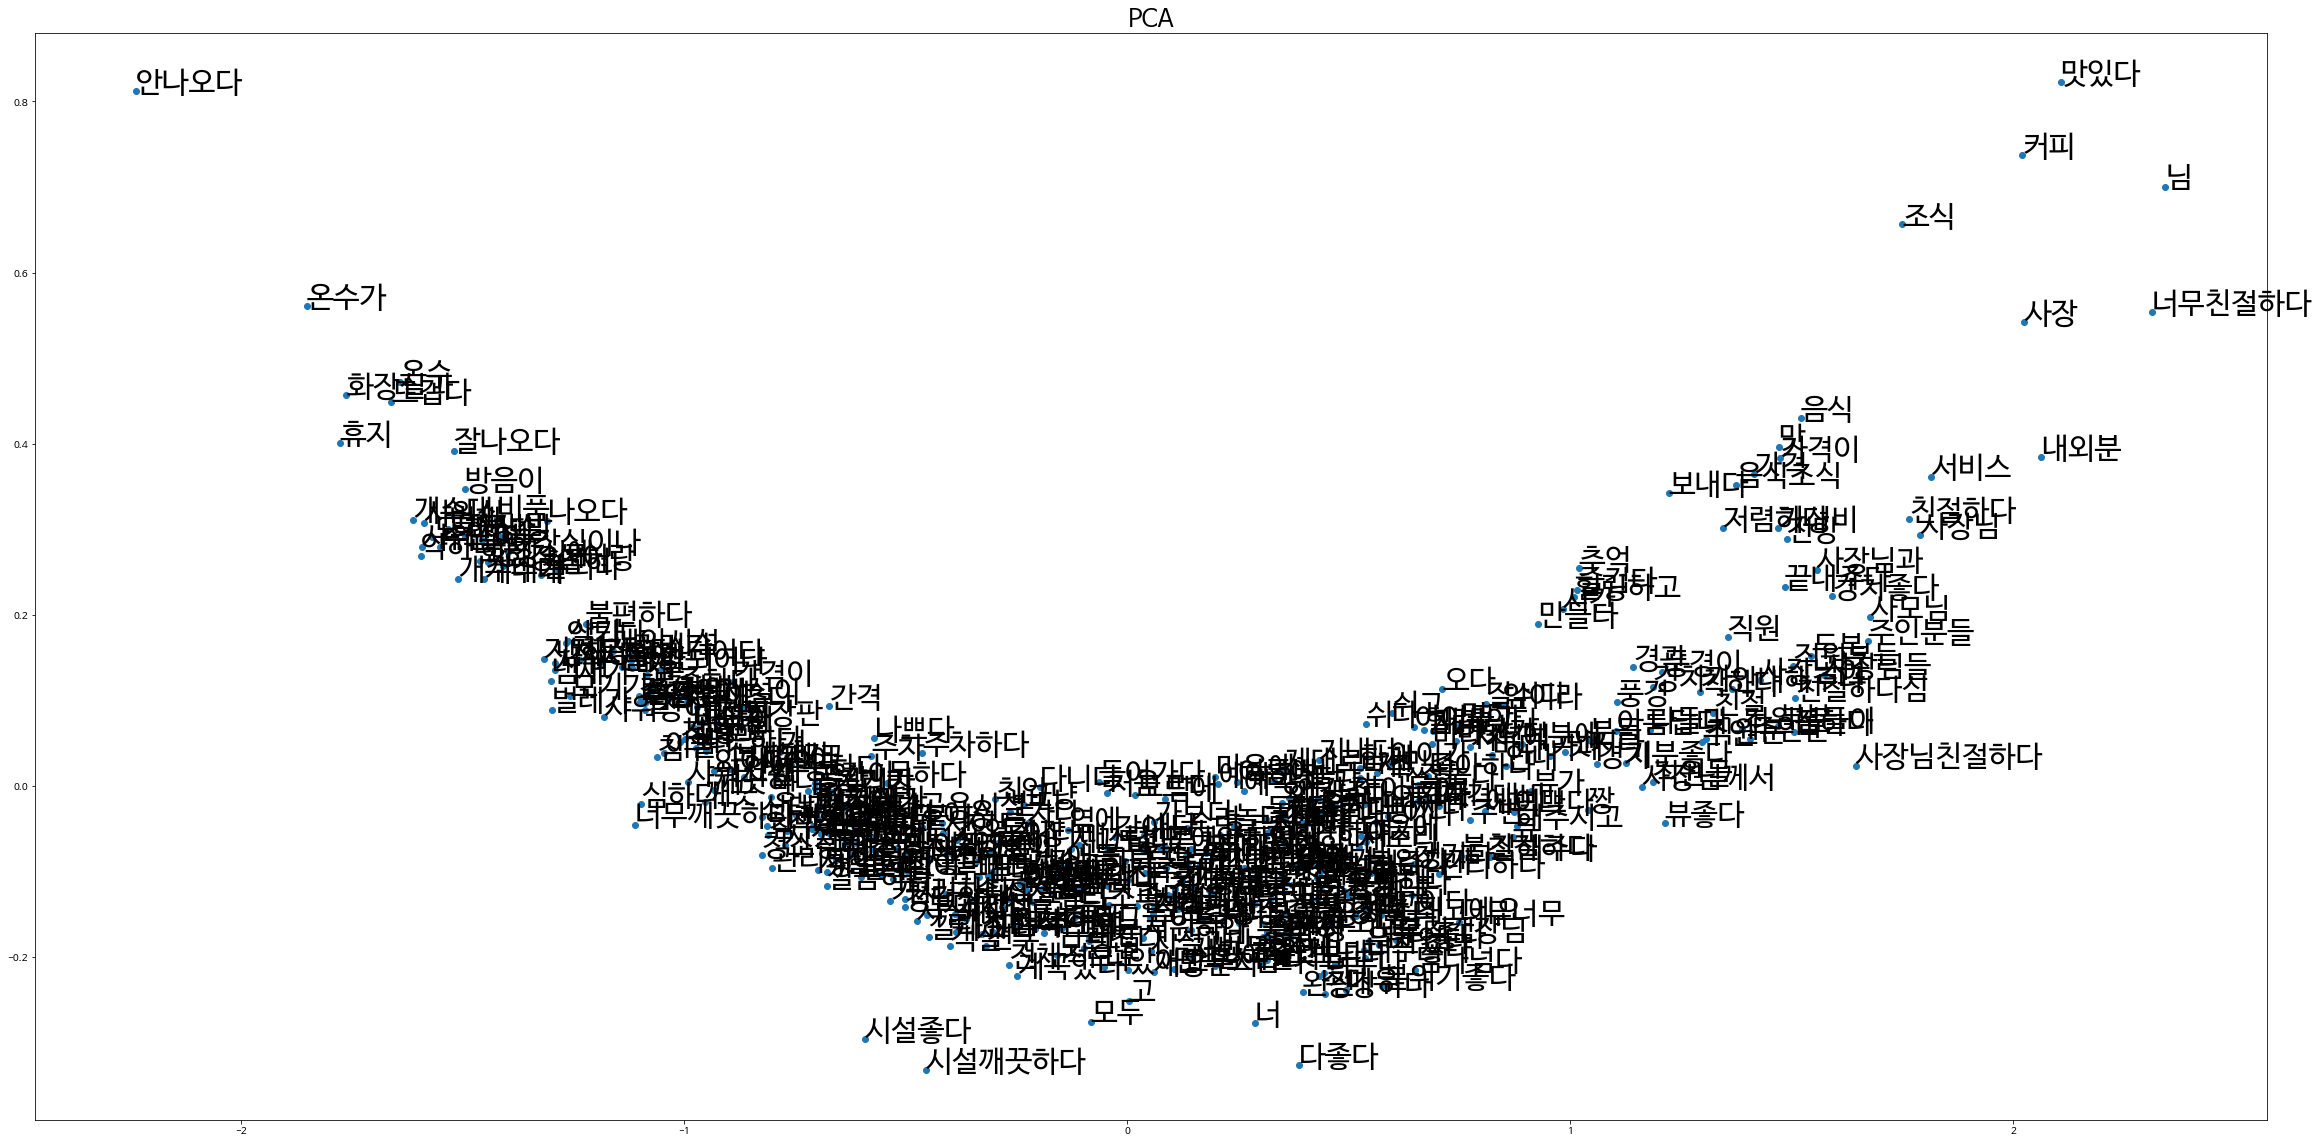

In [32]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(word_vectors)
pca_df = pd.DataFrame(pca_fit, index=vocabs, columns=['x', 'y'])

plt.figure(figsize=(40, 20))
plt.title("PCA", fontsize= 25)
plt.scatter(pca_df["x"], pca_df["y"])

for word, pos in pca_df.iterrows():
    plt.annotate(word, pos, fontsize=30)
plt.show()

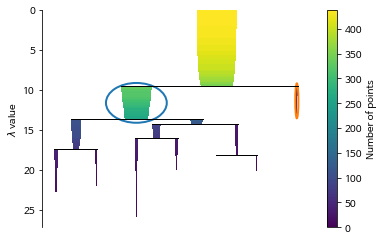

In [33]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(pca_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [39]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=10).fit(pca_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(pca_df)

# 데이터 프레임 만들기
df2 = pd.DataFrame(pca_df)
df2["labels"] = pred_hds

print(np.unique(df2["labels"]), len(df2))
df2.tail(2)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] 438


,x,y,labels
캠장,0.360165,-0.151110,12
스파,-0.041443,-0.139474,8


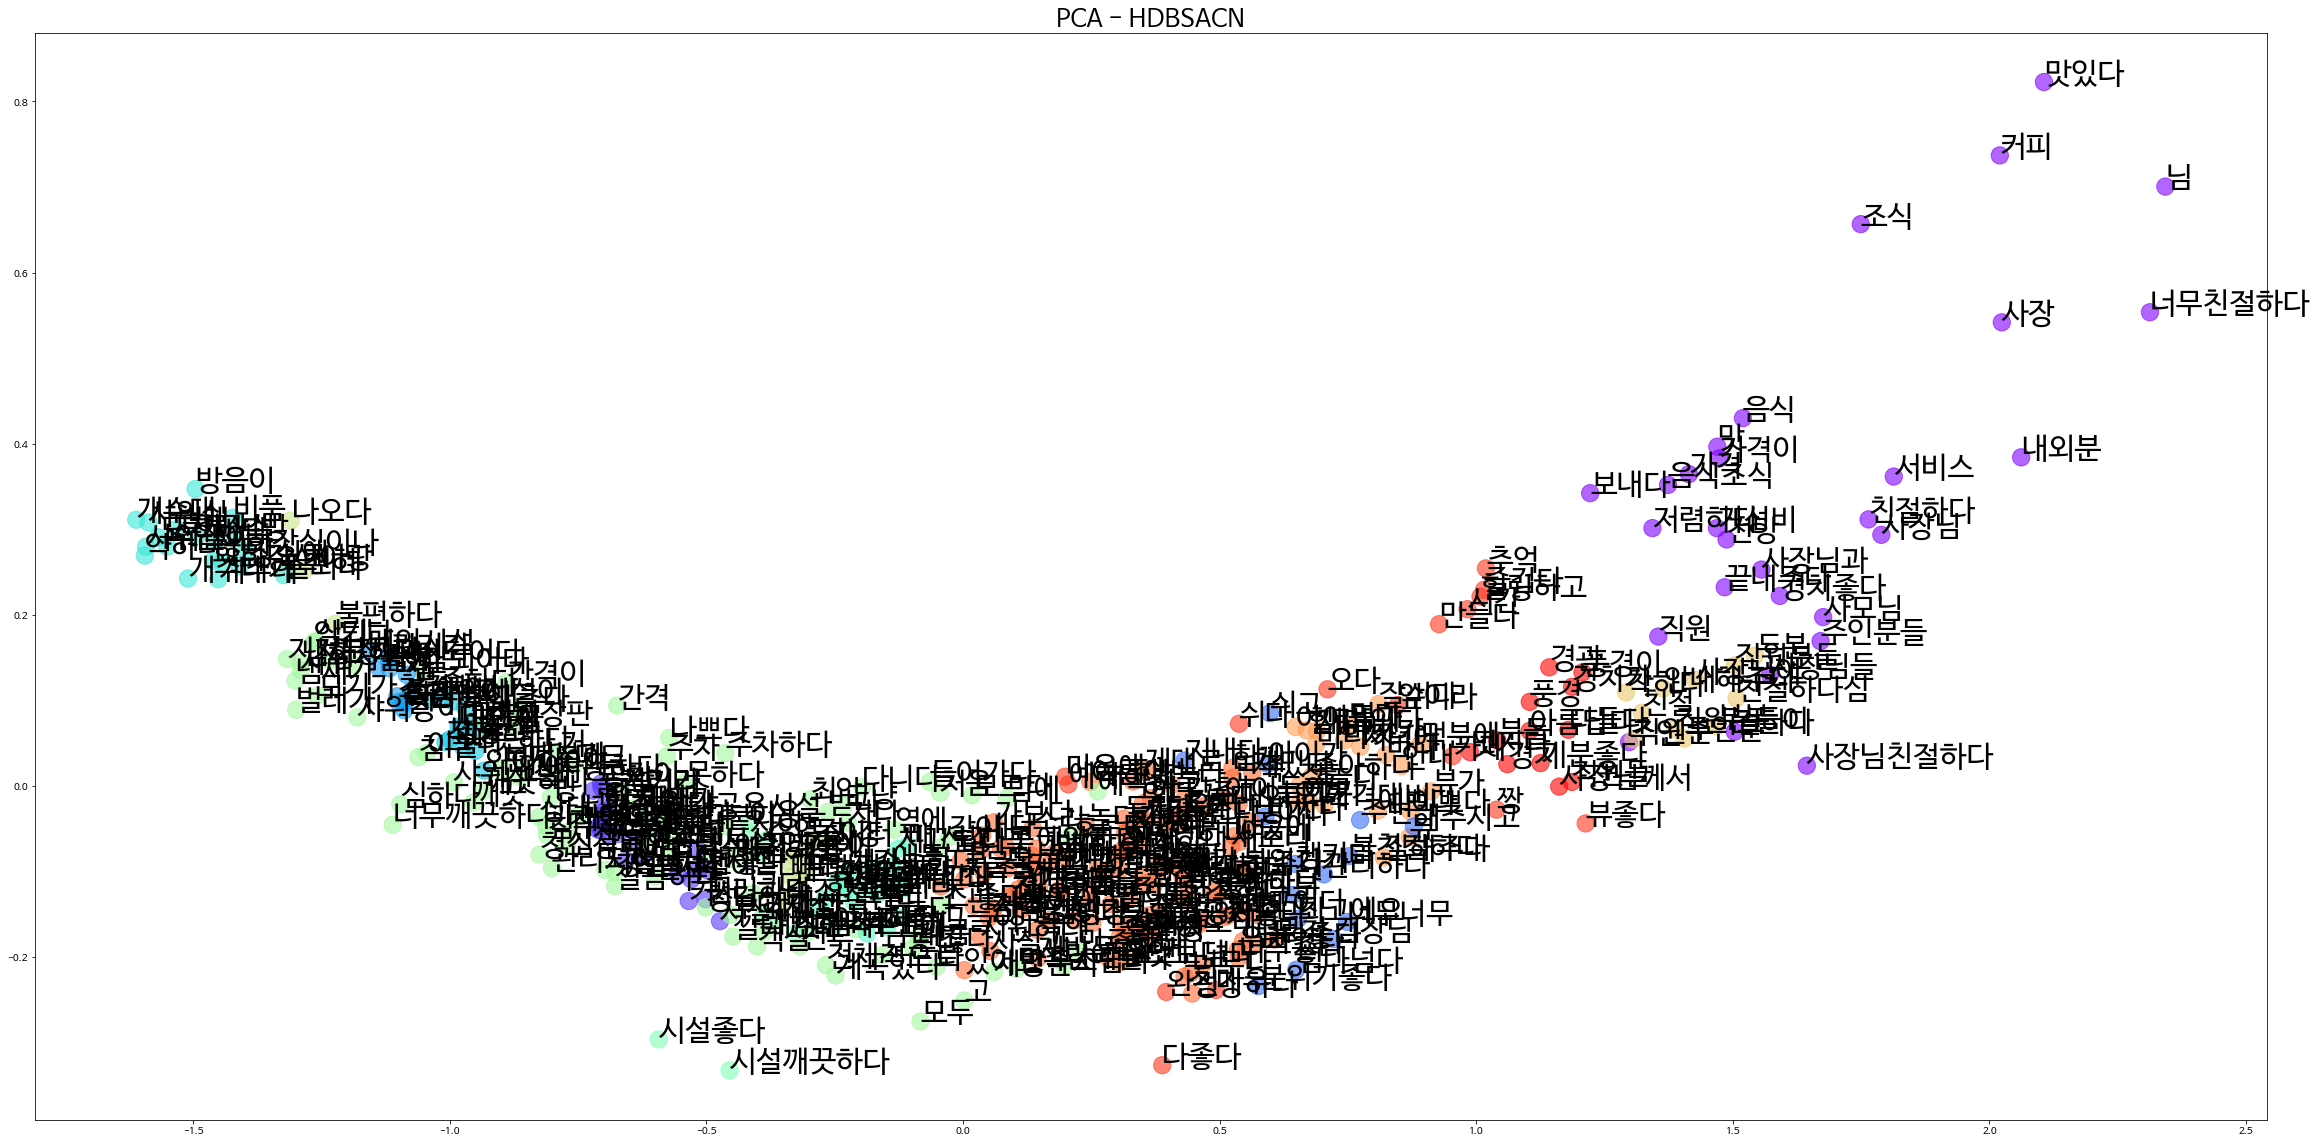

In [40]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
df2.drop(df2[df2['labels']== -1].index,inplace=True)
plt.scatter(df2["x"], df2["y"], c= df2["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df2.index):
    plt.annotate(v, xy=(df2["x"][i], df2["y"][i]), fontsize=30)

plt.show()

In [41]:
for idx in np.unique(df2["labels"]):
    print(f"Group{idx}\n",df2[df2["labels"]==idx].index.tolist())

Group0
 ['서비스', '친절하다', '사장님', '전망', '가격', '음식조식', '맛있다', '저렴하다', '너무친절하다', '경치좋다', '사모님', '보내다', '사장님들', '가성비', '사장님친절하다', '주인', '내외분', '주인분들', '사장님과', '가격이', '사장', '조식', '끝내주다', '음식', '직원', '맛', '절하다', '커피', '님']
Group1
 ['시설', '많다', '시설이', '아쉽다', '카라반', '생각보다', '편시설', '편리하다', '에어컨', '텐트', '편', '놀거리가', '커서', '안좋다', '공간', '소음이', '넉넉하다', '공간이', '따로', '소음', '매점이', '장', '걱정하다']
Group2
 ['너무너무', '주변', '비싸다', '분위기좋다', '관리하다', '분', '캠장님', '지내다', '챙기다', '해주시고', '불친절하다', '쉬고', '최고에요', '아이가', '넘다넘다']
Group3
 ['메인시설', '청결', '없다', '관리가', '화장실이', '멀다', '좁다', '부족하다', '물이', '개', '구비되어다', '수건']
Group4
 ['따뜻하다', '내부', '실내', '침대', '방이', '더럽다', '개별', '데크가', '적다', '냉장고', '와이파이', '샤워시설이', '바닥이']
Group5
 ['화장실', '개수대', '샤워실', '비품', '벌레', '잘되다', '난방', '바닥', '모기', '개수대가', '샤워실이', '화장실이랑', '약하다', '화', '화장실이나', '방음이', '화장실에', '수압이', '계수대']
Group6
 ['', '편하다', '아이들', '나무', '아니다', '이용하다', '힘들다', '가능하다', '없이', '애들', '아늑하다', '시끄럽다', '비다', '그늘', '계속', '나무그늘이', '시설관리', '때', '주변에', '편점', '볼거리', '늘다']
Group7
 ['수영장',

### TSNE 축소법

In [42]:
tsne = TSNE(learning_rate=100)
tsne_fit = tsne.fit_transform(word_vectors)
tsne_df = pd.DataFrame(tsne_fit, index=vocabs, columns=['x', 'y'])

# plt.figure(figsize=(40, 20))
# plt.title("TSNE", fontsize= 25)
# plt.scatter(tsne_df["x"], tsne_df["y"])

# for word, pos in tsne_df.iterrows():
#     plt.annotate(word, pos, fontsize=30)
# plt.show()

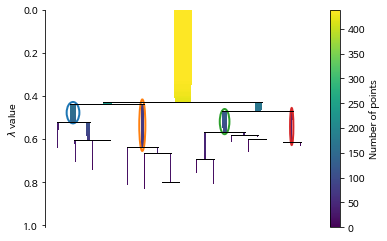

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(tsne_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [47]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5).fit(tsne_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(tsne_df)

# 데이터 프레임 만들기
df3 = pd.DataFrame(tsne_df)
df3["labels"] = pred_hds

print(np.unique(df3["labels"]), len(df3))
df3.tail(2)

[-1  0  1  2  3  4  5  6  7] 438


,x,y,labels
캠장,2.730034,14.963140,1
스파,13.894986,3.372238,6


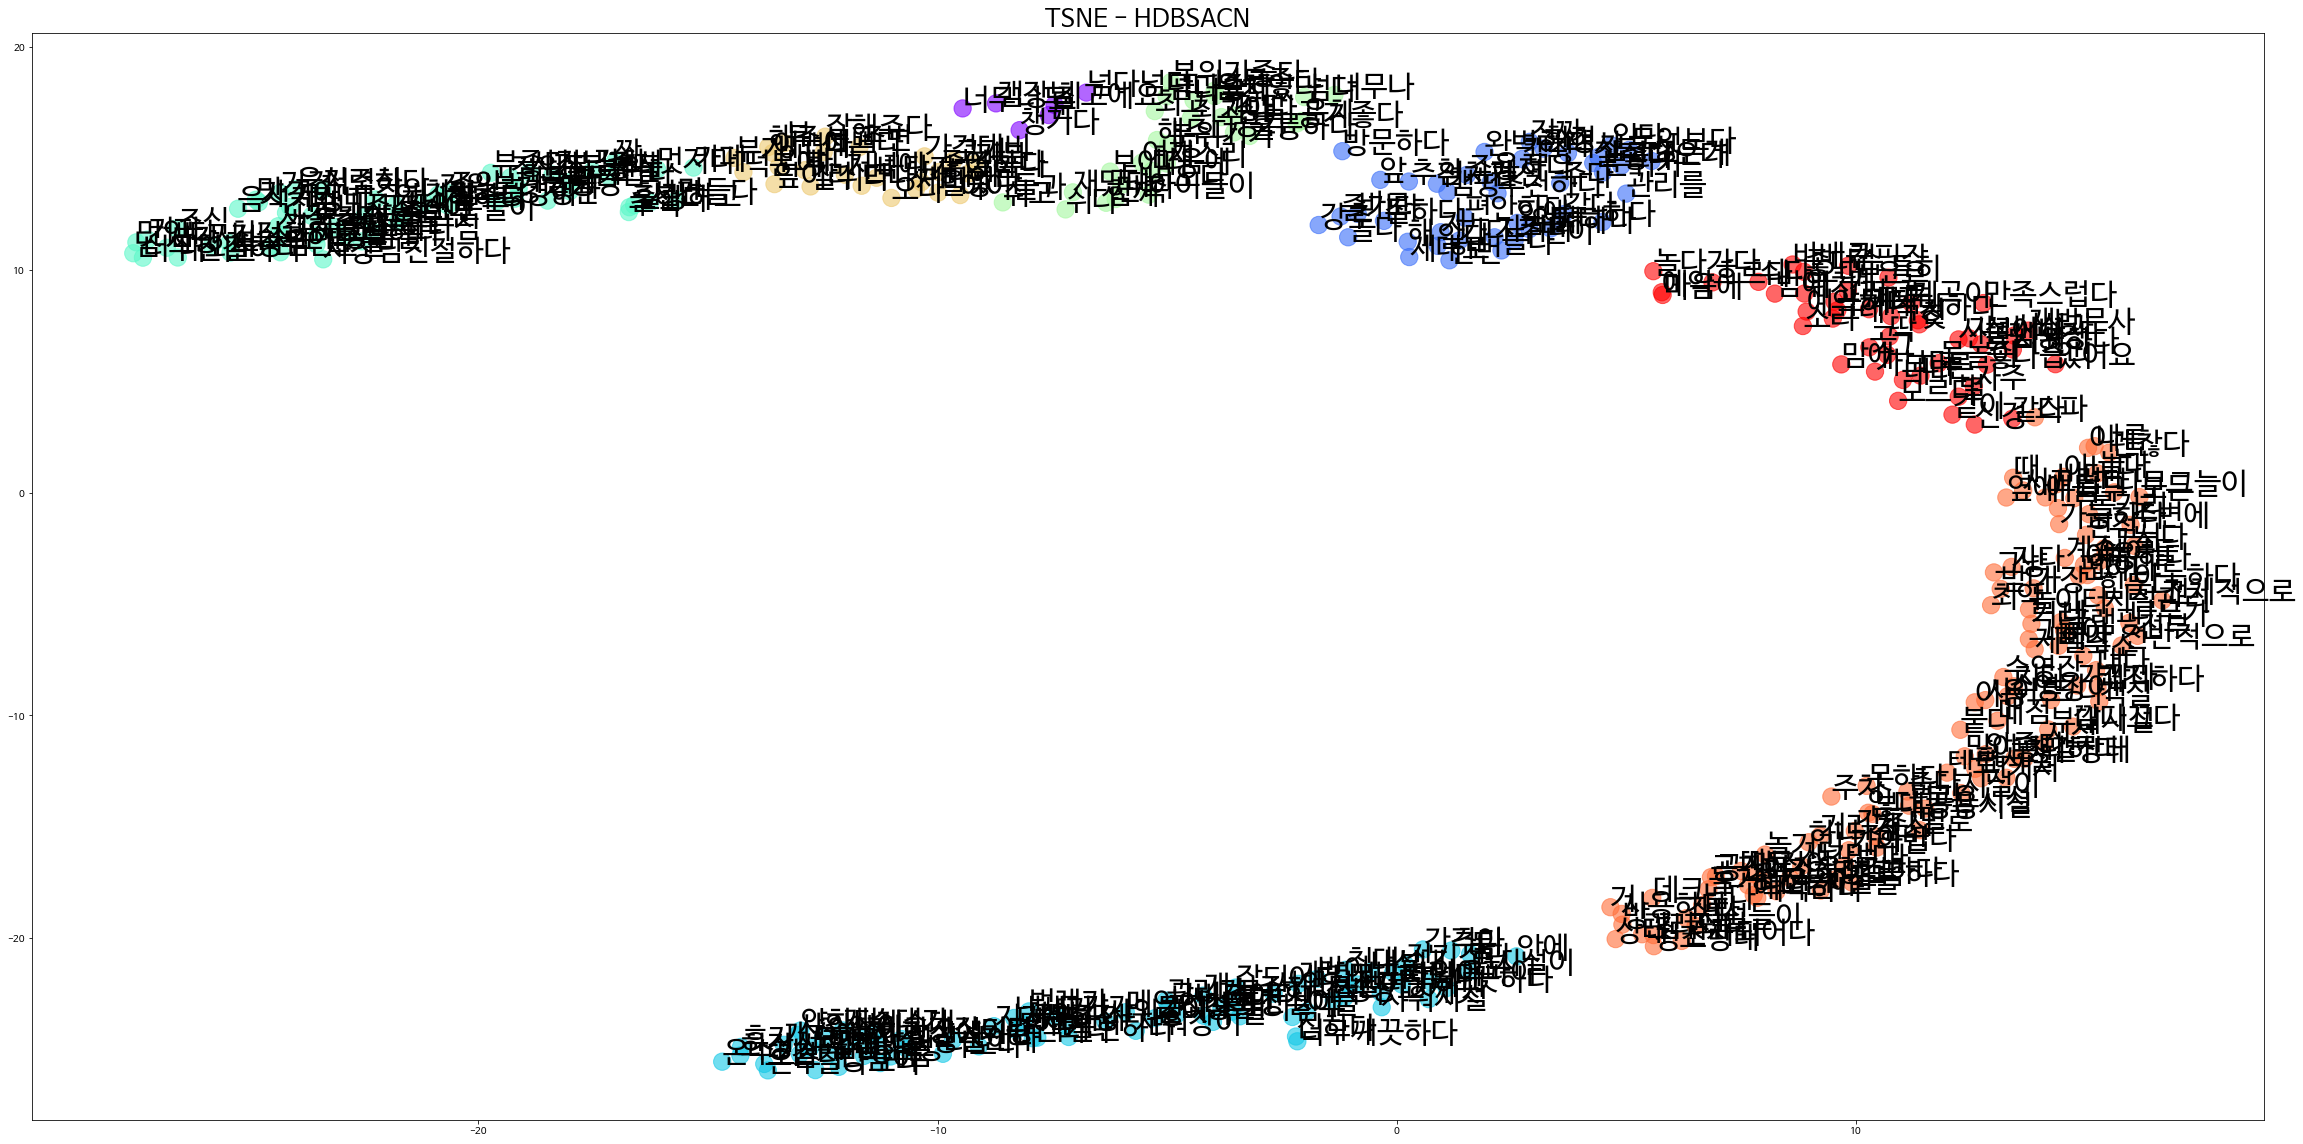

In [48]:
plt.figure(figsize=(40, 20))
plt.title("TSNE - HDBSACN", fontsize= 25)
df3.drop(df3[df3['labels']== -1].index,inplace=True)
plt.scatter(df3["x"], df3["y"], c= df3["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df3.index):
    plt.annotate(v, xy=(df3["x"][i], df3["y"][i]), fontsize=30)

plt.show()

In [49]:
for idx in np.unique(df3["labels"]):
    print(f"Group{idx}\n",df3[df3["labels"]==idx].index.tolist())

Group0
 ['너무너무', '분', '캠장님', '챙기다', '최고에요', '넘다넘다']
Group1
 ['좋다', '분위기', '하다', '가다', '조용하다', '진짜', '놀다', '들다', '바로', '앞에', '캠핑', '잘하다', '편안하다', '앞', '무엇보다', '갈다', '주다', '즐기다', '방문하다', '관리를', '위치가', '접근성', '지키다', '일단', '환경', '완벽하다', '모든게', '알다', '저', '펜션', '추천하다', '한번', '강추', '제대로', '잘쉬다오다', '맑다', '해', '위치하다', '추천', '주변이', '역시', '캠장']
Group2
 ['메인시설', '깨끗하다', '청결', '화장실', '없다', '개수대', '샤워실', '샤워장', '따뜻하다', '비품', '관리가', '불편하다', '화장실이', '잘되어다', '내부', '온수', '벌레', '나오다', '안되다', '벌레가', '물', '멀다', '잘되다', '잘나오다', '깨끗', '좁다', '화장실과', '샤워시설', '부족하다', '심하다', '난방', '냄새', '냄새가', '침구', '바닥', '샤워장이', '모기', '개수대가', '샤워실이', '실내', '온수가', '침대', '물이', '이불', '모기가', '추다', '편시설이', '샤워', '방이', '안에', '더럽다', '화장실이랑', '간격이', '약하다', '화', '전혀', '개별', '지저분하다', '식기', '개', '화장', '화장실이나', '방음이', '데크가', '휴지', '전기장판', '적다', '뜨겁다', '냉장고', '화장실에', '와이파이', '구비되어다', '너무깨끗하다', '수압이', '샤워시설이', '수건', '바닥이', '계수대']
Group3
 ['서비스', '친절하다', '사장님', '전망', '가격', '사장님이', '경치', '직원분들', '음식조식', '친절', '사장님께서', '풍경', '경치가', '맛있다', '즐겁다'